In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipeline, StableDiffusionDepth2ImgPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
device

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
def download_image(url):
    
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

In [3]:
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

img_height = 512
img_width = 512

init_image = download_image(img_url).resize((img_height, img_width))
mask_image = download_image(img_url).resize((img_height, img_width))


In [4]:
#load pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  8.31it/s]


In [5]:
generator = torch.Generator(device=device).manual_seed(42) #random number generator (with deterministic control with seed)

100%|██████████| 35/35 [10:02<00:00, 17.22s/it]


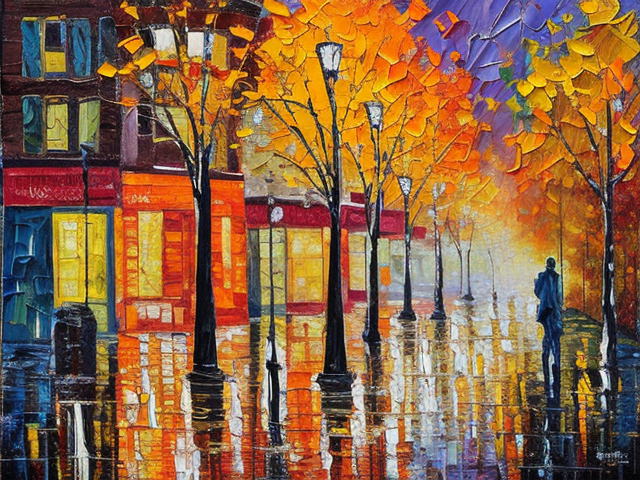

In [6]:
pipe_output = pipe(
    prompt='Palette knife painting of an autumn cityscape',
    negative_prompt = 'Oversaturated, blurry, low quality',
    height=480, #must be divisble by 8
    width=640,
    guidance_scale=8,
    num_inference_steps=35, #35 steps
    generator=generator, #fixed random seed
)

pipe_output.images[0]

100%|██████████| 25/25 [05:07<00:00, 12.29s/it]


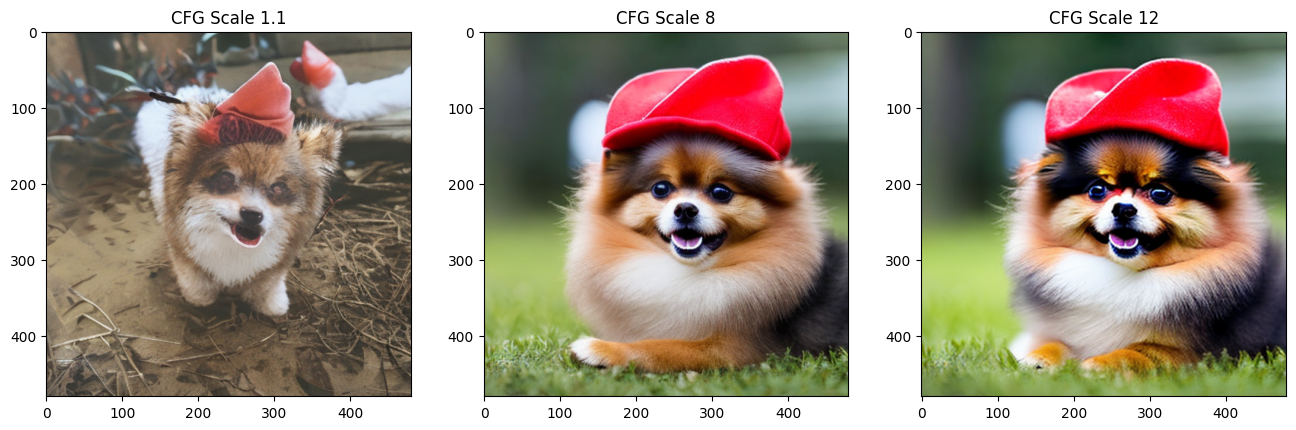

In [7]:
#effect guidance scale
cfg_scales = [1.1, 8, 12]
prompt = 'A pomeranian with red cap'
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))

for i, ax in enumerate(axs):
    im = pipe(
        prompt,
        height = 480,
        width=480,
        guidance_scale=cfg_scales[i],
        num_inference_steps = 25,
        generator = torch.Generator(device=device).manual_seed(42),
    ).images[0]

    ax.imshow(im)
    ax.set_title(f"CFG Scale {cfg_scales[i]}")

In [8]:
#see pipe components
list(pipe.components.keys())

['vae',
 'text_encoder',
 'tokenizer',
 'unet',
 'scheduler',
 'safety_checker',
 'feature_extractor',
 'image_encoder']

In [9]:
#create random fake image
images = torch.randn(1, 3, 512, 512).to(device) * 2 - 1 #[-1, 1] range
print("Input images shape:", images.shape)

#encode to latent space via vae
with torch.no_grad(): 
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean #0.18215 is the scaling factor to match the model's training
print("Encoded latents shape:", latents.shape)

#decode
with torch.no_grad():
    decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


In [10]:
#tokenize prompt text
input_ids = pipe.tokenizer(["A painting of a revenant"])["input_ids"]
print("Input ID -> decoded token")

for input_id in input_ids[0]:
    print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
10171 -> reven
773 -> ant
49407 -> <|endoftext|>


In [11]:
#feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)

with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)["last_hidden_state"]

print("Text embeddinbgs shape", text_embeddings.shape)

Text embeddinbgs shape torch.Size([1, 8, 1024])


In [12]:
#get final text embeddings using pipeline
text_embeddings = pipe._encode_prompt("A painting of a revenant", device, 1, True, "") #use classifier free guidance
text_embeddings.shape

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:313: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


torch.Size([2, 77, 1024])

In [13]:
#test input
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

#model pred
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample

print("UNet output shape:", unet_output.shape)

UNet output shape: torch.Size([1, 4, 64, 64])


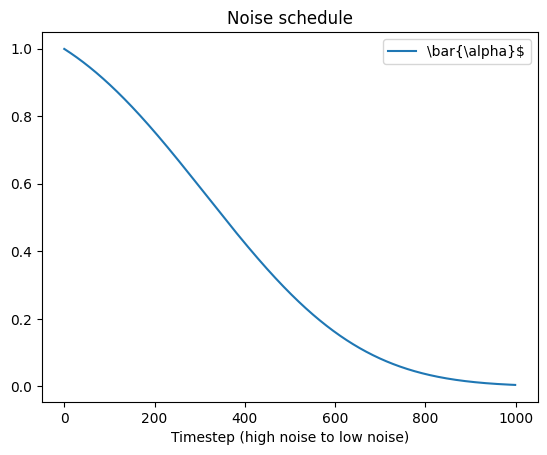

In [14]:
#plot noise schedule
plt.plot(pipe.scheduler.alphas_cumprod, label=r"\bar{\alpha}$")
plt.xlabel("Timestep (high noise to low noise)")
plt.title("Noise schedule")
plt.legend()
plt.show()

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.34.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}



100%|██████████| 25/25 [04:48<00:00, 11.52s/it]


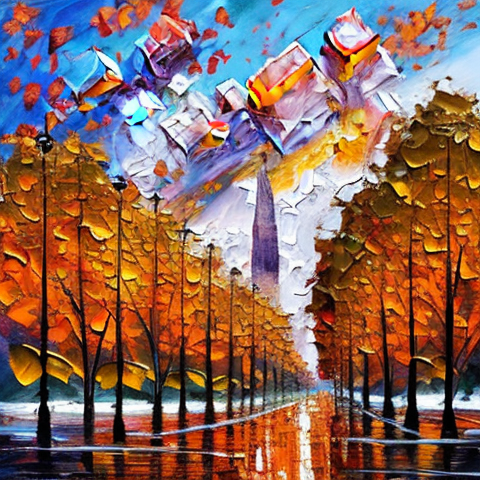

In [15]:
#default is PNDMScheduler, select other scheduler
from diffusers import LMSDiscreteScheduler

pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)
print("Scheduler config:", pipe.scheduler)

#generate image
pipe(
    prompt = 'Palette knife painting of an autumn cityscape',
    height = 480,
    width = 480,
    num_inference_steps = 25,
    generator = torch.Generator(device=device).manual_seed(42),
).images[0]

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:599: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


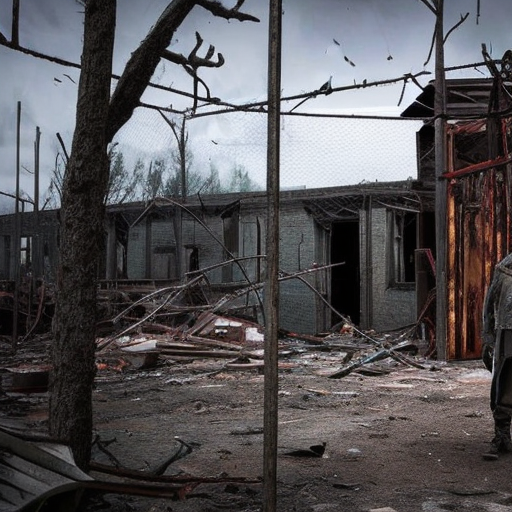

In [16]:
#simple sampling loop
guidance_scale = 8
num_inference_steps = 30
prompt = "An image of an eerie revenant in a dilapidated playground, dark, the setting tells a story"
negative_prompt = "cute, happy, bright, oversaturated, cheering, simplistic, shallow, sunny"

text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

#random strating point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

#prepare scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

#loop
for i, t in enumerate(pipe.scheduler.timesteps):

    latent_model_input = torch.cat([latents] * 2) #expand latent to do classifier free guidance (one for positive one for negative)

    #apply scaling required
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    #predict noise
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    #guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #compute x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

#decode latents to image
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

#view
pipe.numpy_to_pil(image)[0]

In [17]:
import numpy as np

#encode image
init_image_tensor = torch.from_numpy(np.array(init_image).transpose(2, 0, 1)).float() / 255.0 #[0, 1]
init_image_tensor = 2.0 * init_image_tensor - 1.0 # [-1, 1]
init_image_tensor = init_image_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    init_image_latents = pipe.vae.encode(init_image_tensor).latent_dist.sample() * pipe.vae.config.scaling_factor
    

Text(0.5, 1.0, 'Result')

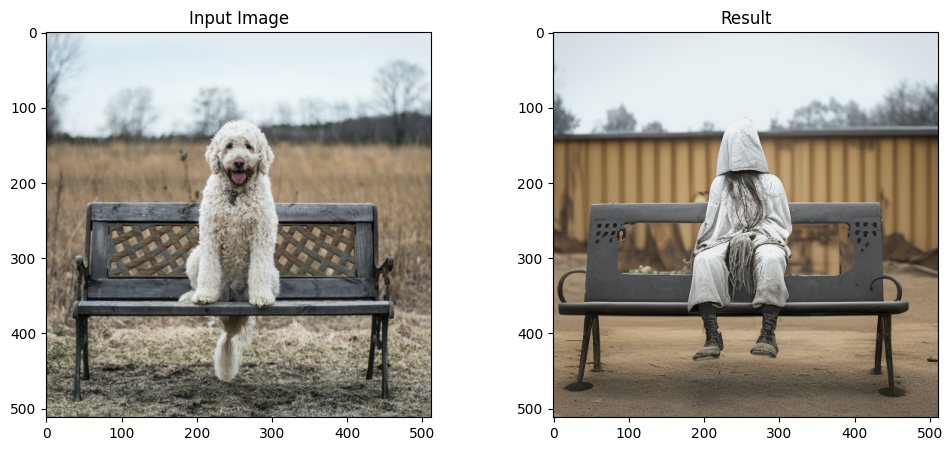

In [18]:
guidance_scale = 7.5
num_inference_steps = 30
strength = 0.6
prompt = "An image of an eerie revenant in a dilapidated playground, dark, the setting tells a story"

#encode
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, "")

#scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

#latent variable (controlling the range of timesteps depending on the strength, lower strength means smaller timesteps range)
init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
t_start = max(num_inference_steps - init_timestep, 0)
timesteps = pipe.scheduler.timesteps[t_start:]

#first timestep (starting point for adding noise)
latent_timestep = timesteps[:1]

#add noise
noise = torch.randn((1, 4, 64, 64), device=device, generator=torch.Generator(device=device).manual_seed(42))
latents = pipe.scheduler.add_noise(init_image_latents, noise, latent_timestep)

#sampling loop
for i, t in enumerate(timesteps):

    #expand latents
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    #predict
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
    #guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #compute x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

#decode
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    result_image = pipe.vae.decode(latents_norm).sample

result_image = (result_image / 2 + 0.5).clamp(0, 1).squeeze()
result_image = (result_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
result_image = Image.fromarray(result_image)

#view
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image)
axs[0].set_title("Input Image")
axs[1].imshow(result_image)
axs[1].set_title("Result")

In [19]:
#use img2img pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.88it/s]
